# PSF fitting for Gen2 benchmark analysis

This notebook demonstrates how point spread functions can be parameterized for the gen2-analysis framework. The end product is a pair of B-splines that describes the parameters of a Moffat function (see http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/IRF_PSF.html) as a function of muon energy and zenith angle.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tables
import pandas as pd
import numpy as np
from toolz import memoize
from gen2_analysis import plotting, surfaces, util, angular_resolution

import photospline
from scipy import optimize
from autograd.misc.flatten import flatten_func
import autograd
import autograd.numpy as n
import os

First, load MC data. Each entry comes with a zenith angle (cos_theta), energy, angular error, and effective area weight (aeff). The effective area weight has units *sr m^2 GeV*.

For demonstration purposes we generate a fake dataset where we know the exact underlying effective area and point-spread function.

In [2]:
from scipy import stats

class DummyDataset:
    """
    A fake dataset to demonstrate PSF and selection efficiency fitting.
    """

    # reference surface on which tracks are generated
    surface = surfaces.Cylinder(1600, 1600)

    def king_params(self, energy, cos_theta):
        angular_resolution_scale = np.where(energy < 1e6, 0.05*(6-np.log10(energy)), 0)
        # dip at the horizon, improvement with energy up to 1e6
        sigma = 10**(np.where(np.abs(cos_theta)<0.15, (cos_theta*3)**2 - 1.2, (cos_theta/1.05)**2 - 1.) + angular_resolution_scale)
        # tails contract at the horizon, and with energy up to 1e6
        gamma = 10**((-0.5 - (cos_theta/3)**2) + angular_resolution_scale/2) + 1
        return sigma, gamma
    
    def selection_efficiency(self, energy, cos_theta):
        # soft turn-on at threshold energy (higher threshold in vertical directions)
        threshold = 10**(2*(3-np.exp(-np.abs(cos_theta))))
        return (1-np.exp(-energy/threshold))
    
    @staticmethod
    def _sample_powerlaw(emin, emax, gamma, size):
        """returns x, dP/dx"""
        p = stats.uniform().rvs(size=size)
        x = (p*(emax**(1-gamma) - emin**(1-gamma)) + emin**(1-gamma))**(1./(1-gamma))
        return x, (1-gamma)*(x**-gamma)/(emax**(1-gamma)-emin**(1-gamma))

    @memoize
    def sample(self, size=1000):
        cos_theta = stats.uniform(-1, 2).rvs(size=size)
        energy, dPdE = self._sample_powerlaw(1e3, 1e9, 1.4, size)
        # 1/(number of events injected per unit solid angle, area, energy)
        effective_area_weight = (4*np.pi)*self.surface.azimuth_averaged_area(cos_theta)/dPdE/size

        # set weights to zero for samples rejected by cut
        mask = np.where(stats.uniform().rvs(size=size) < self.selection_efficiency(energy, cos_theta), 1, 0)

        sigma, gamma = self.king_params(energy, cos_theta)

        # sample from moffat/king distribution by numerically inverting the CDF (~2000 samples/s on Apple M1)
        opening_angle = angular_resolution.king(sigma=sigma, gamma=gamma).rvs(size=size)

        return pd.DataFrame({
            "aeff": effective_area_weight*mask,
            "energy": energy,
            "cos_zenith": cos_theta,
            "opening_angle": opening_angle,
        })


Now, actually generate the sample. This can take ~minutes, as the angular CDF needs to be inverted numerically in order to sample from it.

In [3]:
dataset = DummyDataset()
dats = dataset.sample(size=100000)

In a real application you would have data from an actual detector simulation. For reference, here's how you would load an IceCube-Gen2 simulation dataset:

In [4]:
@memoize
def load_dataset(hdf_fname):
    dfs = {}
    # read each table into a DataFrame
    with tables.open_file(hdf_fname) as hdf:
        for tab in 'MCMuon', 'MuonEffectiveArea', 'SplineMPEMuEXDifferential', 'LineFit', 'SplineMPE_recommendedFitParams', 'SplineMPE_recommendedDirectHitsC':
            dfs[tab] = pd.DataFrame(hdf.get_node('/'+tab).read_where('exists==1')).set_index(['Run', 'Event', 'SubEvent', 'SubEventStream'])
    # apply event selection
    mask = (dfs['LineFit']['speed'] < 0.6)&\
        (dfs['SplineMPE_recommendedFitParams']['rlogl'] < 8.5)&\
        (dfs['SplineMPE_recommendedDirectHitsC']['n_dir_doms'] > 6)&\
        (dfs['SplineMPE_recommendedDirectHitsC']['dir_track_length'] > 120)
    # angular reconstruction error
    def cartesian_components(df):
        theta = df['zenith']
        phi = df['azimuth']
        return -np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), -np.cos(theta)
    def opening_angle(df1, df2):
        x1, y1, z1 = cartesian_components(df1)
        x2, y2, z2 = cartesian_components(df2)
        return np.arccos(x1*x2+y1*y2+z1*z2)
    # pack relevant quantities into a single DataFrame
    dats = pd.DataFrame(
        {
            'opening_angle':
                np.degrees(
                      opening_angle(
                          dfs['MCMuon'].loc[mask],
                          dfs['SplineMPEMuEXDifferential'].loc[mask]
                      )
                ),
            'aeff':  dfs['MuonEffectiveArea']['value'].loc[mask],
            'energy': dfs['MCMuon']['energy'].loc[mask],
            'cos_zenith': np.cos(dfs['MCMuon']['zenith'].loc[mask]),
        }
    )
    return dats
# fiducial_surface = surfaces.get_fiducial_surface("Sunflower", 240)
# dats = load_dataset('/Users/jakob/Documents/IceCube/metaprojects/icerec-lite/build/ErrorEstimator_GEN2.hdf5')

Get a feeling for the range of energies and zenith angles we're dealing with

In [5]:
dats.describe()

,aeff,energy,cos_zenith,opening_angle
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000
mean,1.021963e+12,2.733045e+06,-0.000797,10.243867
std,1.658821e+13,3.177444e+07,0.577742,31.621416
min,0.000000e+00,1.000085e+03,-1.000000,0.002627
25%,0.000000e+00,2.047163e+03,-0.501875,0.399378
50%,0.000000e+00,5.565930e+03,-0.001367,1.103560
75%,5.590994e+07,3.087783e+04,0.500217,3.842662
max,7.259627e+14,9.973420e+08,0.999967,180.000000


To parameterize the PSF, we first construct a 3-dimensional histogram log10(energy), cos(zenith), and angular error

In [6]:
bins = [np.linspace(3, 8, 21), np.linspace(-1, 1, 41), np.linspace(0, 90**(1./2), 101)**2]
counts = np.histogramdd(np.vstack((np.log10(dats['energy']), dats['cos_zenith'], dats['opening_angle'])).T, bins=bins)[0]

Plot a few slices of the histogram. We want to find a function that describes these slices.

(In this dummy example we have an exact parameterization of the underlying CDF, but in a real application you would not.)

Text(0.5, 1.0, '$E_{\\mu} \\in \\rm [{17.8 \\,} TeV, {31.6 \\,} TeV)$')

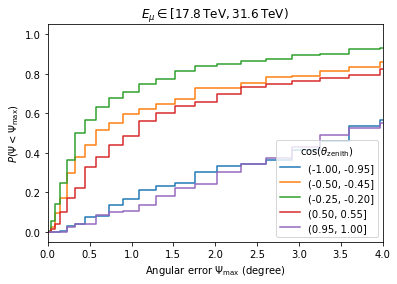

In [7]:
ei = 5
for ci in (0, 10, 15, 30, 39):
    y = counts[ei,ci,:].cumsum()
    plt.plot(*plotting.stepped_path(bins[2], y/y[-1]), label='({:.2f}, {:.2f}]'.format(*bins[1][ci:ci+2]))
plt.xlim(0,4)
plt.xlabel(r'Angular error $\Psi_{\max}$ (degree)')
plt.ylabel(r'$P(\Psi < \Psi_{\max})$')
plt.legend(title=r'$\cos(\theta_{\rm zenith})$')
plt.title(
    r'$E_{{\mu}} \in \rm [{}, {})$'.format(
        *([plotting.format_energy(r"{%.1f \,}", e) for e in 10**bins[0][ei:ei+2]])
    )
)

The following is in principle quite simple, but requires an unfortunate amount of boilerplate to set up. What we do here is define, and then optimize, a likelihood that scores the number of events in each angular error bin against the prediction from a King/Moffet distribution. The parameters of that distribution are each functions of the muon energy and zenith angle, parameterized with a spline surface. The final likelihood is the sum of the Poisson term and a second-order difference penalty on the spline coefficients. To improve the accuracy and speed of the fit, we use `autograd` to generate a function that calculates the derivative of the total likelihood w.r.t. the spline coefficients. 

In [8]:

def slicemultiply(A,B,p):
    sa = A.shape
    sb = B.shape

    newaxes = list(range(p,B.ndim)) + list(range(0,p))

    B = B.transpose(newaxes)
    # use of autograd numpy wrappers to propagate gradients through this operation
    nonp = n.prod([B.shape[i] for i in range(1,B.ndim)])
    B = n.reshape(B,(B.shape[0],nonp))

    C = n.dot(A.transpose(), B)
    C = n.reshape(C,[A.shape[1]] + [sb[i] for i in newaxes[1:]])

    # Now invert the permutation we did to B on C
    invaxes = newaxes[:]
    for i in range(0,len(newaxes)): invaxes[newaxes[i]] = i
    C = C.transpose(invaxes)

    return C

def splinebasis(coords, knots, order):
    bspline = np.vectorize(photospline.bspline, excluded=(0, 3))
    nsplines = [len(knots[i])-order[i]-1 for i in range(len(knots))]
    return [bspline(knots[i], np.asarray(coords[i])[None,:], np.arange(nsplines[i])[:,None], order[i]) for i in range(len(knots))]

def grideval(basis, coefficients):
    result = coefficients
    for i in range(result.ndim):
        result = slicemultiply(basis[i], result, i)
    return result

def make_penalty(penorder, knots, order):
    """
    Construct a weighted sum of N-th order penalty matrix for spline coefficients
    """
    def divdiff(knots, order, m, i):
        # Calculate divided difference coefficients
        # in order to estimate derivatives.

        if m == 0:
            return np.asarray([1.])

        num = np.append(0,divdiff(knots,order,m-1,i+1)) - np.append(divdiff(knots,order,m-1,i),0)
        dem = (knots[i+order+1] - knots[i+m])/(order-(m-1))
        return num/dem

    def penalty_matrix(penorder, knots, splineorder):
        nspl = len(knots)-splineorder-1
        D = np.zeros((nspl,nspl),dtype=float)
        for i in range(0, nspl-penorder):
            D[i][i:i+penorder+1] = divdiff(knots,splineorder,penorder,i)

        return D

    def calcP(nsplines, knots, dim, order, porders):
        nspl = nsplines[dim]
        knots = knots[dim]

        D = np.zeros((nspl,nspl))
        for porder,coeff in porders.items():
            if coeff == 0: continue
            D1 = penalty_matrix(porder, knots, order)
            D += np.sqrt(coeff)*D1

        def prodterm(i):
            if (i == dim):
                return D
            else:
                return np.eye(nsplines[i],dtype=float)

        a = prodterm(0)
        i = 1
        while i < len(nsplines):
            b = prodterm(i)
            a = np.kron(a,b)
            i = i+1
        return a
    ndim = len(knots)
    nsplines = [len(knots[i])-order[i]-1 for i in range(ndim)]
    penalty = calcP(nsplines,knots,0,order[0],penorder[0])
    for i in range(1,ndim):
        penalty = penalty + calcP(nsplines,knots,i,order[i],penorder[i])
    return np.asarray(penalty)

def king_cdf(x, sigma, gamma):
    """
    Cumulative version of the King function, used to parameterize the PSF in XMM and Fermi
    
    See: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/IRF_PSF.html
    """
    s2 = sigma**2
    x2 = x**2
    return (1.-1./gamma)/(2*(gamma-1.)*s2)*(2*gamma*s2 - (2*gamma*s2 + x2)*(x2/(2*gamma*s2) + 1)**-gamma)

def fit_psf(bins, counts, nknots=(7,10), smooth=1e1):
    """
    Find splines that describe a tabulated point spread function    
    """

    def pad_knots(knots, order=2):
        """
        Pad knots out for full support at the boundaries
        """
        pre = knots[0] - (knots[1]-knots[0])*np.arange(order, 0, -1)
        post = knots[-1] + (knots[-1]-knots[-2])*np.arange(1, order+1)
        return np.concatenate((pre, knots, post))

    order = [2,2]
    knots = [pad_knots(np.linspace(bins[i][0], bins[i][-1], nknots[i]), order[i]) for i in range(2)]
    centers = [(e[1:]+e[:-1])/2 for e in bins]
    basis = splinebasis(centers, knots, order)
    
    def cdf(x, sigma, gamma):
        s2 = sigma**2
        x2 = x**2
        return (1.-1./gamma)/(2*(gamma-1.)*s2)*(2*gamma*s2 - (2*gamma*s2 + x2)*(x2/(2*gamma*s2) + 1)**-gamma)
    
    def model(args, edges, N):
        sigma, gamma = args
        
        sigma = 10.**sigma[...,None]
        gamma = (10.**gamma[...,None]) + 1.
        return N[...,None]*(king_cdf(edges[1:][None,None,...], sigma, gamma) - king_cdf(edges[:-1][None,None,...], sigma, gamma))
    
    penalties = [make_penalty(p,knots,order) for p in [({2:10*smooth}, {2:smooth/50},), ({2:smooth}, {2:smooth},) ]]
    
    def penalty_term(coefficients):
        return n.sum(((n.dot(p, c.flatten())**2).sum() for p,c in zip(penalties, coefficients)))
    
    # total number of events in each energy/zenith bin
    N = counts.sum(axis=2)
    
    def llh(coefficients):
        args = [grideval(basis, c) for c in coefficients]
        # add a tiny term to prevent the expectation from being identically zero
        lam = model(args, bins[2], N) + np.finfo(float).tiny
        ts = -2*(counts*n.log(lam) - lam) #- gammaln(x+1))
        return n.sum(ts) + penalty_term(coefficients)
    
    coefficients = [np.zeros([b.shape[0] for b in basis])]*2

    flat_llh, unflatten, coefficients = flatten_func(llh, coefficients)
    
    def callback(xk):
        if callback.i % 100 == 0:
            print(callback.i, flat_llh(xk))
        callback.i += 1
    callback.i = 0
    args, fval, res = optimize.fmin_l_bfgs_b(flat_llh, coefficients, autograd.elementwise_grad(flat_llh), factr=1e7, callback=callback)

    coefficients = unflatten(args)
    return [
        {
            'coefficients': c,
            'order': order,
            'knots': knots
        }
        for c in coefficients
    ]



In [9]:
splines = fit_psf(bins, counts, smooth=1)

0 [-97082.91849385]
100 [-170537.86718733]


Plot the fit parameters to check for undue wiggliness. $\sigma$ describes the overall scale of the PSF (similar to the polar Gaussian case; smaller is better), while $\gamma$ controls the slope of the tail to large angles (larger is better).

Also plot the true parameters as dotted lines for reference.

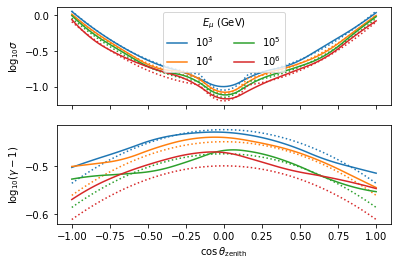

In [10]:
x = np.linspace(-1, 1, 101)
fig, axes = plt.subplots(2,1, sharex=True)
for loge in 3, 4, 5, 6:
    sigma, gamma = dataset.king_params(10**loge, x)
    for i in range(2):
        spl = splines[i]
        basis = splinebasis([[loge], x], spl['knots'], spl['order'])
        line = axes.flat[i].plot(x, grideval(basis, spl['coefficients']).T, label='$10^{{{:.0f}}}$'.format(loge))[0]
        if i == 0:
            axes.flat[i].plot(x, np.log10(sigma), color=line.get_color(), ls=':')
        if i == 1:
            axes.flat[i].plot(x, np.log10(gamma-1), color=line.get_color(), ls=':')


axes.flat[1].set_xlabel(r'$\cos\theta_{\rm zenith}$')
axes.flat[1].set_ylabel(r'$\log_{10}(\gamma-1)$')
axes.flat[0].set_ylabel(r'$\log_{10}\sigma$')
axes.flat[0].legend(title=r'$E_{\mu}$ (GeV)', ncol=2)

Evaluate the parameterized CDF at each slice

In [11]:
centers = [(e[1:]+e[:-1])/2 for e in bins[:-1]]
sigma, gamma_m1 = [grideval(splinebasis(centers, spl['knots'], spl['order']), spl['coefficients']) for spl in splines]
psi = np.linspace(0, 10, 101)
psf_vals = king_cdf(psi[None,...], 10**sigma[...,None], 10**(gamma_m1[...,None])+1)

Compare the evaluated CDF compared to the source histogram.

Text(0.5, 1.0, '$E_{\\mu} \\in \\rm [{17.8 \\,} TeV, {31.6 \\,} TeV)$')

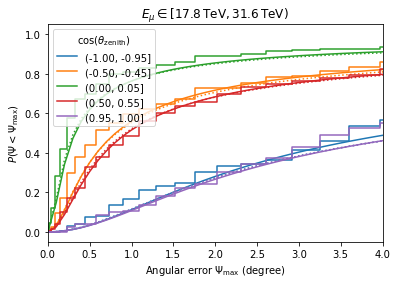

In [12]:
ei = 5
for ci in (0, 10, 20, 30, 39):
    y = counts[ei,ci,:].cumsum()
    line = plt.plot(*plotting.stepped_path(bins[2], y/y[-1]), label='({:.2f}, {:.2f}]'.format(*bins[1][ci:ci+2]))[0]
    plt.plot(psi, psf_vals[ei,ci], color=line.get_color())
    # plot "true" PSF for comparison
    sigma, gamma = dataset.king_params(10**ei, (bins[1][ci]+bins[1][ci+1])/2)
    plt.plot(psi, angular_resolution.king(sigma=sigma, gamma=gamma).cdf(psi), color=line.get_color(), ls=':')
plt.xlim(0,4)
plt.xlabel(r'Angular error $\Psi_{\max}$ (degree)')
plt.ylabel(r'$P(\Psi < \Psi_{\max})$')
plt.legend(title=r'$\cos(\theta_{\rm zenith})$')
plt.title(
    r'$E_{{\mu}} \in \rm [{}, {})$'.format(
        *([plotting.format_energy(r"{%.1f \,}", e) for e in 10**bins[0][ei:ei+2]])
    )
)

Now, write the results of the fit to a file, and verify that the functor used in gen2_analysis returns the same as the one we used for fitting (modulo floating point precision)

In [13]:
def to_splinetable(spline_spec):
    # construct an empty SplineTable, the bad way
    data, weights = photospline.ndsparse.from_data(np.eye(2), weights=np.eye(2))
    template = photospline.glam_fit(data, weights, [[0,1],[0,1]], spline_spec['knots'], spline_spec['order'], [1e6]*2, [0]*2)
    # now, abuse the array protocol to get a writable view into the coefficient array
    class transplant(object):
        def __init__(self, donor):
            self.__array_interface__ = dict(donor.__array_interface__)
            self.__array_interface__['data'] = (self.__array_interface__['data'][0], False)
    np.array(transplant(template.coefficients), copy=False)[:] = spline_spec['coefficients']
    return template

In [14]:
from gen2_analysis.angular_resolution import SplineKingPointSpreadFunction
for label, spl in zip(('sigma', 'gamma'), splines):
    to_splinetable(spl).write('kingpsf.{}.fits'.format(label))
psf = SplineKingPointSpreadFunction(os.getcwd()+'/kingpsf')

Calculating spline basis...
Reticulating splines...
	Convolving bases...
		Convolving dimension 0
		Convolving dimension 1
	Flattening residuals matrix...
Transforming fit array...
Computing least square solution...
Analyze[88]: 0.000037 s
Factorize[88]: 0.000017 s
Solve[88]: 0.000014 s
Done: cleaning up
Calculating spline basis...
Reticulating splines...
	Convolving bases...
		Convolving dimension 0
		Convolving dimension 1
	Flattening residuals matrix...
Transforming fit array...
Computing least square solution...
Analyze[88]: 0.000030 s
Factorize[88]: 0.000011 s
Solve[88]: 0.000007 s
Done: cleaning up


Text(0.5, 1.0, '$E_{\\mu} \\in \\rm [{17.8 \\,} TeV, {31.6 \\,} TeV)$')

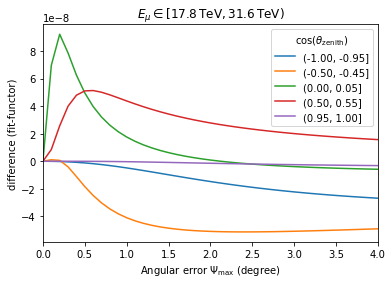

In [15]:
ax = plt.gca()
ei = 5
for ci in (0, 10, 20, 30, 39):
    y = counts[ei,ci,:].cumsum()
    from_fit = psf_vals[ei,ci]
    from_function = psf(np.radians(psi), 10**centers[0][ei], centers[1][ci])
    plt.plot(psi, from_fit-from_function, label='({:.2f}, {:.2f}]'.format(*bins[1][ci:ci+2]))
ax.set_xlim(0,4)
ax.set_xlabel(r'Angular error $\Psi_{\max}$ (degree)')
ax.set_ylabel(r'difference (fit-functor)')
ax.legend(title=r'$\cos(\theta_{\rm zenith})$')
ax.set_title(
    r'$E_{{\mu}} \in \rm [{}, {})$'.format(
        *([plotting.format_energy(r"{%.1f \,}", e) for e in 10**bins[0][ei:ei+2]])
    )
)

# Fitting the muon selection efficiency

While we're here, we can also fit the muon selection efficiency, which we can use together with the area of the fiducial surface to calculate the muon effective area.

In [16]:
def get_muon_selection_efficiency(
    dataframe,
    fiducial_surface,
    nfiles=1000,
    cos_theta=np.linspace(-1, 1, 21),
    energy=np.logspace(2, 11, 46)
):
    edges = [energy, cos_theta]
    sample = np.vstack((dataframe['energy'], dataframe['cos_zenith'])).T
    weights = dataframe['aeff']/nfiles
    counts = np.histogramdd(sample, bins=edges)[0]

    bincontent, _ = np.histogramdd(sample, weights=weights, bins=edges)
    squaredweights, _ = np.histogramdd(sample, weights=weights**2, bins=edges)
    
    # convert GeV m^2 sr to m^2
    bin_volume = 2*np.pi*np.outer(*map(np.diff, edges))
    # normalize to geometric area
    geometric_area = np.vectorize(fiducial_surface.average_area)(edges[1][:-1], edges[1][1:])[None,:]

    binerror = np.sqrt(squaredweights)
    for target in bincontent, binerror:
        target /= bin_volume
        target /= geometric_area
    
    return bincontent, binerror, edges

In [17]:
def fit_muon_selection_efficiency(efficiency, error, binedges, smoothing=1):
    from gen2_analysis.util import center
   
    def pad_knots(knots, order=2):
        """
        Pad knots out for full support at the boundaries
        """
        pre = knots[0] - (knots[1]-knots[0])*np.arange(order, 0, -1)
        post = knots[-1] + (knots[-1]-knots[-2])*np.arange(1, order+1)
        return np.concatenate((pre, knots, post))

    z = efficiency
    w = 1./error**2
    
    for i in range(z.shape[1]):
        # deweight empty declination bands
        if not (z[:,i] > 0).any():
            w[:,i] = 0
            continue
        # extrapolate efficiency with a constant
        last = np.where(z[:,i] > 0)[0][-1]
        zlast = z[last-10:last,i]
        mask = zlast != 0
        w[last:,i] = 1./((error[last-10:last,i][mask]**2).mean())
        z[last:,i] = zlast[mask].mean()
        first = np.where(z[:,i] > 0)[0][0]
        w[:first,i] = 1./((error[first:first+10,i]**2).mean())
    w[~np.isfinite(w) | ~np.isfinite(z)] = 0
    centers = [center(np.log10(binedges[0])), center(binedges[1])]
    knots = [pad_knots(np.log10(binedges[0]), 2), pad_knots(binedges[1], 2)]
    order = [2,2]
    z, w = photospline.ndsparse.from_data(z, w)
    spline = photospline.glam_fit(z, w, centers, knots, order, smoothing=[5*smoothing, 10*smoothing], penaltyOrder=[2,2])
    
    return spline

Calculating spline basis...


/var/folders/1_/hs0775c97ms0m4p0yvl38vm40000gn/T/ipykernel_8298/2411896534.py:13: RuntimeWarning: divide by zero encountered in true_divide
  w = 1./error**2


Text(0.5, 0, 'Muon energy at fiducial surface (GeV)')

Reticulating splines...
	Convolving bases...
		Convolving dimension 0
		Convolving dimension 1
	Flattening residuals matrix...
Transforming fit array...
Computing least square solution...
Analyze[1034]: 0.001498 s
Factorize[1034]: 0.009789 s
Solve[1034]: 0.000425 s
Done: cleaning up


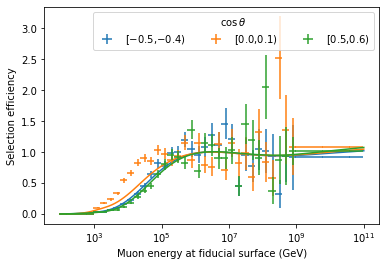

In [18]:
# fiducial_surface = surfaces.get_fiducial_surface('Sunflower', 240)
seleff, seleff_err, edges = get_muon_selection_efficiency(dats, dataset.surface, nfiles=1)
seleff_spline = fit_muon_selection_efficiency(seleff, seleff_err, edges)

for ci in 5, 10, 15:
    
    x = np.linspace(2, 11, 101)
    y = seleff_spline.grideval([x, [(edges[1][ci]+edges[1][ci+1])/2.]]).squeeze()
    line = plt.plot(10**x, y)[0]
    
    x = 10**((np.log10(edges[0][1:]) + np.log10(edges[0][:-1]))/2.)
    xerr = edges[0][1:]-x, x-edges[0][:-1]
    y = seleff[:,ci]
    yerr = seleff_err[:,ci]
    line = plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='None', label=r'[${:.1f}$,${:.1f}$)'.format(edges[1][ci], edges[1][ci+1]), color=line.get_color())

plt.semilogx()
plt.legend(title=r'$\cos\theta$', ncol=3)
plt.ylabel('Selection efficiency')
plt.xlabel('Muon energy at fiducial surface (GeV)')

In [19]:
seleff_spline.write('muon_selection_efficiency.fits')